In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools
import pandas as pd
import matminer
import sys
sys.path.append("/Users/Ashwin/Desktop/git/matminer")
from pymatgen import Composition, Element
from matminer.descriptors.composition_features import ElementFractionAttribute
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import datasets
from sklearn import svm
import datetime
from sklearn.multiclass import OneVsRestClassifier
%matplotlib inline

In [2]:
training_file = 'data/oqmd_all.csv'

In [3]:
training_set = pd.read_csv(training_file, delim_whitespace=True, na_values=["None", np.inf])
comp_objects = [Composition(comp) for comp in training_set["comp"]]
training_set = training_set.assign(comp_obj=comp_objects)
training_set.head()

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,comp_obj
0,Li1,-1.892002,17.8351,NaN,0.000,0.004605,0.004605,(Li)
1,Mg1,-1.539604,22.9639,NaN,0.000,0.002719,0.002719,(Mg)
2,Kr1,0.011256,41.4146,NaN,7.367,0.015315,0.015315,(Kr)
3,Na1,-1.299101,32.9826,NaN,0.000,0.003780,0.003780,(Na)
4,Pd1,-5.158533,15.2088,NaN,0.000,0.018186,0.018186,(Pd)


In [4]:
%%time
training_set['is_groundstate'] = False
for gid, group in training_set.groupby('comp'):
    if group.shape[0] > 1:
        group = group.sort_values('energy_pa', ascending=True)    
    training_set.loc[group.iloc[0].name, 'is_groundstate'] = True

CPU times: user 4min 3s, sys: 1.91 s, total: 4min 5s
Wall time: 4min 7s


In [5]:
training_set = training_set[training_set['is_groundstate']]

In [6]:
def calc_attributes(training_set):
    training_set_updated = ElementFractionAttribute().featurize_dataframe(training_set, col_id='comp_obj')
    return training_set_updated
training_set = calc_attributes(training_set)

In [7]:
training_set.head()

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,comp_obj,is_groundstate,Ac,...,Tl,Tm,U,V,W,Xe,Y,Yb,Zn,Zr
25,Rb1,-0.963073,89.6163,NaN,0.000,0.0,0.0,(Rb),True,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,V1,-8.940979,13.1686,0.002313,0.000,0.0,0.0,(V),True,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
70,Ne1,-0.029318,22.2120,NaN,11.657,0.0,NaN,(Ne),True,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,Rh1,-7.269405,13.9855,-0.014167,0.000,0.0,0.0,(Rh),True,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,Ir1,-8.854920,14.4652,0.003235,0.000,0.0,0.0,(Ir),True,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
cols_to_drop = ['comp', 'energy_pa', 'volume_pa', 'magmom_pa', 'bandgap', 'stability', 'comp_obj', 'is_groundstate', 'delta_e']

In [9]:
min_value = training_set.min().delta_e
training_set.replace(min_value, np.nan, inplace=True)
training_set.dropna(inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ne. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ar. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for He. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


# Benchmark Random Forest + KFold Validation

In [115]:
#Descretize into pos/neg formation energy

delta_e = np.array(training_set['delta_e'], dtype=float)
#will hold pos/neg for each element in delta_e
energy_range = np.zeros(np.shape(delta_e), dtype=str)
for i in range(len(delta_e)):
    if delta_e[i] < 0:
        energy_range[i] = 'neg'
    else:
        energy_range[i] = 'pos'
energy_range

array(['p', 'p', 'p', ..., 'n', 'n', 'n'], 
      dtype='<U1')

In [116]:
rfc = RandomForestClassifier(n_estimators=10, criterion='gini', min_samples_split=2, n_jobs=-1)
rfc.fit(training_set.drop(cols_to_drop, axis=1), energy_range)
rfc_prediction = rfc.predict(training_set.drop(cols_to_drop, axis=1))

In [117]:
%%time
from sklearn.model_selection import ShuffleSplit
clf = svm.SVC(kernel='linear', C=1e3)
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state =0)
scores = cross_val_score(rfc, training_set.drop(cols_to_drop, axis=1), energy_range, cv=cv)
print("Average Score: ", scores.mean(), " and standard deviation of: ", scores.std())

Average Score:  0.916052291982  and standard deviation of:  0.00284224203738
CPU times: user 48.9 s, sys: 2 s, total: 50.9 s
Wall time: 19.8 s


# Split Dataset by Element

In [99]:
def get_elements(comp):
    return comp.elements

def split_by_element(training_set, element):
    """
    Splits dataframe into two datasets: one without the element inputted and the other with. Provides datasets for machine learning models.
    
    Args:
        training_set: pandas data frame containing training data
        element: string represenation of an element
    Returns:
        Two dataframes -- one with compounds with the element in it, the other without
    """
    #print(training_set.head())
    #for comp in training_set['comp_obj']:
        #if Element(element) in comp.elements:
        
    training_set['els'] = training_set['comp_obj'].apply(get_elements)
    training_set['is_in'] = False
    for count, el_list in enumerate(training_set['els']):
        if Element(element) in el_list:
            training_set.iloc[count, training_set.columns.get_loc('is_in')] = True
    
    with_element = training_set[training_set['is_in']]
    without_element = training_set[training_set['is_in'] == False]
    return with_element, without_element

In [100]:
#Predict Enthalpy Delta given training data without Aluminum in it
with_, without = split_by_element(training_set, 'Al')

In [101]:
cols_to_drop += ['els', 'is_in']

In [102]:
# Training data

#Discrete into pos/neg formation energy for regression
delta_e_without = np.array(without['delta_e'], dtype=float)
#pos/neg values for classification
energy_range_without = np.zeros(np.shape(delta_e_without), dtype=str)
for i in range(len(delta_e_without)):
    if delta_e_without[i] < 0:
        energy_range_without[i] = 'neg'
    else:
        energy_range_without[i] = 'pos'

# Prediction data
delta_e_with = np.array(with_['delta_e'], dtype=float)
energy_range_with = np.zeros(np.shape(delta_e_with), dtype=str)
for i in range(len(delta_e_with)):
    if delta_e_with[i] < 0:
        energy_range_with[i] = 'neg'
    else:
        energy_range_with[i] = 'pos'

# Classification

Labels = energy_range_without <br>
Samples = without.drop(cols_to_drop, axis=1)

### Random Forest Classifier

In [121]:
rfc = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, n_jobs=-1)
rfc.fit(without.drop(cols_to_drop, axis=1), energy_range_without)
rfc_prediction = rfc.predict(with_.drop(cols_to_drop, axis=1))

In [122]:
rfc.score(with_.drop(cols_to_drop, axis=1), energy_range_with)

0.70993452889268427

In [123]:
pd.crosstab(energy_range_with, rfc_prediction, rownames=['actual'], colnames=['predicted'])

predicted,n,p
actual,,
n,688,937
p,82,1806


### Decision Tree Classifier

In [106]:
dtc = DecisionTreeClassifier()
dtc.fit(without.drop(cols_to_drop, axis=1), energy_range_without)
dtc_prediction = dtc.predict(with_.drop(cols_to_drop, axis=1))

In [107]:
dtc.score(with_.drop(cols_to_drop, axis=1), energy_range_with)

0.70196413321947049

In [108]:
pd.crosstab(energy_range_with, dtc_prediction, rownames=['actual'], colnames=['predicted'])

predicted,n,p
actual,,
n,632,993
p,54,1834


# Regression

### Random Forest Regressor

In [128]:
rf_model = RandomForestRegressor(n_jobs=-1)
rf_model.fit(without.drop(cols_to_drop, axis=1), delta_e_without)
rf_prediction = rf_model.predict(with_.drop(cols_to_drop, axis=1))

In [129]:
rf_model.score(with_.drop(cols_to_drop, axis=1), delta_e_with)

0.80363835392532668

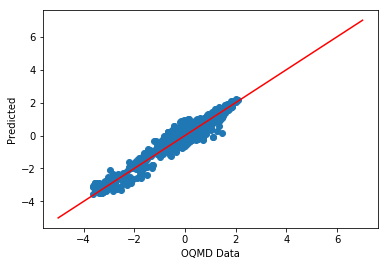

In [130]:
plt.scatter(delta_e_with, rf_prediction)
plt.plot(range(-5, 8), range(-5, 8), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

### Decision Tree Regressor

In [112]:
dt_model = DecisionTreeRegressor()
dt_model.fit(without.drop(cols_to_drop, axis=1), delta_e_without)
dt_prediction = dt_model.predict(with_.drop(cols_to_drop, axis=1))

In [113]:
dt_model.score(with_.drop(cols_to_drop, axis=1), delta_e_with)

0.75423111459657999

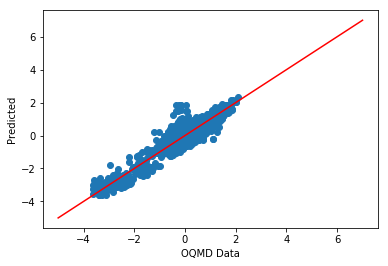

In [114]:
plt.scatter(delta_e_with, dt_prediction)
plt.plot(range(-5, 8), range(-5, 8), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")